In [1]:
import inspect
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import pymc3 as pm
from pymc3 import sampling_jax

import theano.tensor as tt
import arviz as az

# %matplotlib

/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/pymc3/sampling_jax.py:24: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [4]:
from pymc3 import sampling_jax

In [5]:
track = pd.read_csv('../examples/data/modes.csv')
track.head()

frac_age  delta_nu_fit      nu_max  nu_0_1     nu_0_2     nu_0_3  \
0  0.000016     11.884045  150.680452     0.0  34.481794  49.329712   
1  0.000017     12.140476  154.893200     0.0  35.203007  50.376320   
2  0.000017     12.343045  158.238356     0.0  35.772049  51.202159   
3  0.000018     12.503403  160.898485     0.0  36.222266  51.855582   
4  0.000018     12.633487  163.061612     0.0  36.587368  52.385499   

      nu_0_4     nu_0_5     nu_0_6      nu_0_7  ...     nu_0_32     nu_0_33  \
0  63.195077  75.913367  87.630758   99.483102  ...  392.064627  403.710370   
1  64.548471  77.583389  89.569246  101.679667  ...  400.620086  412.538305   
2  65.616199  78.900744  91.100159  103.413323  ...  407.368711  419.505074   
3  66.460893  79.942765  92.312228  104.785371  ...  412.708426  425.019262   
4  67.145867  80.787635  93.295718  105.898357  ...  417.037759  429.491253   

      nu_0_34     nu_0_35     nu_0_36     nu_0_37     nu_0_38     nu_0_39  \
0  415.297909  426.924218  438.655667  450.550178  462.546781  474.658899   
1  424.386957  436.252351  448.212638  460.326691  472.558635  484.919720   
2  431.563921  443.619056  455.762984  468.048949  480.469626  493.018551   
3  437.245702  449.452226  461.742276  474.164224  486.734715  499.427290   
4  441.854064  454.184875  466.594022  479.127384  491.819429  504.626946   

      nu_0_40  surface_he4  
0  486.825847     0.239966  
1  497.325734     0.239967  
2  505.616340     0.239968  
3  512.179364     0.239969  
4  517.505773     0.239969  

[5 rows x 44 columns]

In [6]:
def asy_background(n, epsilon, alpha, delta_nu, nu_max):
    n_max = nu_max / delta_nu - epsilon
    return delta_nu * (n + epsilon + 0.5 * alpha * (n - n_max)**2)

def he_amplitude(nu, b0, b1, lib=tt):
    return b0 * nu * lib.exp(- b1 * nu**2)

def he_glitch(nu, b0, b1, tau_he, phi_he, lib=tt):
    return he_amplitude(nu, b0, b1, lib=lib) * lib.sin(4 * np.pi * tau_he * nu + phi_he)

In [7]:
def cz_amplitude(nu, c0):
    return c0 / nu**2

def cz_glitch(nu, c0, tau, phi, lib=tt):
    return cz_amplitude(nu, c0) * lib.sin(4 * np.pi * tau * nu + phi)

In [8]:
def glitch(nu, tau, phi):
    return tt.sin(4 * np.pi * tau * nu + phi)

## Model many

In [9]:
# profile = track.loc[track['frac_age'] < 0.5].iloc[-1]
n_stars = 10
profiles = track.loc[(track['frac_age'] > 0.01) & (track['frac_age'] < 0.8)].sample(n_stars)
profiles

frac_age  delta_nu_fit       nu_max  nu_0_1  nu_0_2      nu_0_3  \
577  0.451946    132.357953  2965.084508     0.0     0.0  525.555854   
571  0.435634    133.310863  2994.520151     0.0     0.0  528.669371   
693  0.742733    114.044484  2420.549267     0.0     0.0  464.072830   
507  0.255011    143.413553  3312.159518     0.0     0.0  561.485269   
664  0.674977    118.532910  2550.427295     0.0     0.0  479.569195   
605  0.526481    127.902204  2829.064245     0.0     0.0  510.951197   
656  0.655550    119.798113  2587.471914     0.0     0.0  483.874217   
550  0.377651    136.647221  3098.220827     0.0     0.0  539.532770   
544  0.360843    137.599152  3127.992521     0.0     0.0  542.622237   
573  0.441084    132.993159  2984.696922     0.0     0.0  527.631753   

         nu_0_4      nu_0_5       nu_0_6       nu_0_7  ...      nu_0_32  \
577  661.798719  803.016232   944.626392  1085.725475  ...  4419.955090   
571  666.125153  808.548201   951.283366  1093.476827  ...  4452.197510   
693  579.313685  697.749362   818.136360   938.206771  ...  3799.816941   
507  712.241696  867.397465  1022.105592  1175.832242  ...  4793.721227   
664  599.513353  723.417908   848.931546   974.137511  ...  3950.751371   
605  641.666701  777.270214   913.642379  1049.631962  ...  4269.399635   
656  605.198456  730.665813   857.632230   984.291489  ...  3993.306573   
550  681.300127  827.939411   974.616896  1120.631476  ...  4564.957725   
544  685.636311  833.476083   981.279118  1128.380896  ...  4597.097366   
573  664.682188  806.703212   949.063244  1090.891980  ...  4441.448814   

         nu_0_33      nu_0_34      nu_0_35      nu_0_36      nu_0_37  \
577  4552.303589  4681.356076  4811.986204  4940.767938  5066.630418   
571  4585.709246  4715.656518  4847.412241  4977.386077  5104.541315   
693  3912.129481  4022.563837  4130.167596  4234.813042  4338.323044   
507  4938.494978  5082.409900  5221.992324  5364.081614  5504.314733   
664  4068.262596  4184.269669  4297.790055  4408.234704  4516.349195   
605  4394.280266  4521.222242  4646.529921  4769.567475  4889.382635   
656  4112.263605  4229.798351  4344.949452  4457.100124  4566.657104   
550  4702.343507  4836.618173  4971.233452  5105.314331  5236.913182   
544  4735.553186  4871.906210  5006.497121  5141.736823  5274.573252   
573  4574.576326  4704.220686  4835.602554  4965.179562  5091.904874   

         nu_0_38      nu_0_39      nu_0_40  surface_he4  
577  5189.464225  5310.197927  5431.916916     0.216440  
571  5228.610719  5350.366459  5472.737476     0.217267  
693  4443.450753  4551.746029  4662.639385     0.201612  
507  5642.048963  5776.532824  5908.257173     0.226485  
664  4624.380933  4735.180712  4848.879449     0.205099  
605  5006.657393  5123.323934  5242.348361     0.212631  
656  4675.656190  4787.165046  4901.606456     0.206078  
550  5365.421487  5491.103705  5616.005591     0.220226  
544  5404.375469  5531.256724  5656.960531     0.221088  
573  5215.559979  5336.969473  5459.120159     0.216989  

[10 rows x 44 columns]

In [14]:
nu_index = [f'nu_0_{i}' for i in range(10, 30)]
n = np.arange(10, 30)

nus = profiles[nu_index].to_numpy().astype(float).T

In [15]:
nus.shape

(20, 10)

In [16]:
ns = n[:, np.newaxis]
ns.shape

(20, 1)

In [17]:
numaxs = profiles['nu_max'].to_numpy()
dnus = profiles['delta_nu_fit'].to_numpy()

In [21]:
with pm.Model() as model_asy:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2, shape=n_stars)
    alpha = pm.Lognormal('alpha', np.log(0.001), 1.0, shape=n_stars)
    delta_nu = pm.Normal('delta_nu', dnus, 1.0, shape=n_stars)
    nu_max = pm.Normal('nu_max', numaxs, numaxs*0.05, shape=n_stars)

    nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)

    nu_model = pm.Deterministic('nu_model', asy_background(ns, epsilon, alpha, delta_nu, nu_max))
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nus)

In [22]:
with model_asy:
    trace_asy = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:11.627353
Transformation time =  0 days 00:00:00.057220


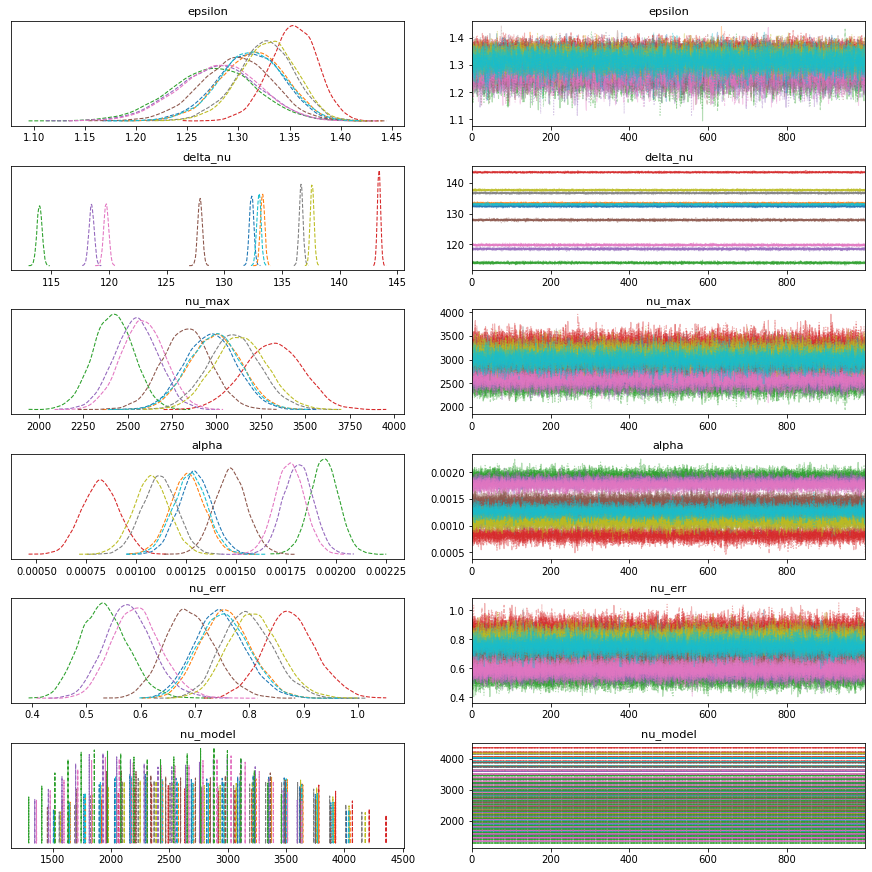

In [23]:
with model_asy:
    ax = az.plot_trace(trace_asy, compact=True, combined=True)

Use these as initial values?

In [24]:
with pm.Model() as model_glitch_he:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2, shape=n_stars)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0, shape=n_stars)
    delta_nu = pm.Normal('delta_nu', dnus, 1.0, shape=n_stars)
    nu_max = pm.Normal('nu_max', numaxs, numaxs*0.05, shape=n_stars)
    
    b0 = pm.Lognormal('b0', np.log(1/numaxs), 1.0, shape=n_stars)
    b1 = pm.Lognormal('b1', np.log(1/numaxs**2), 1.0, shape=n_stars)
    tau = pm.Lognormal('tau', np.log(0.0005), 0.5, shape=n_stars)

#     log_tau = pm.Normal('log_tau', 0.0 + -0.99 * np.log(numax), 0.6)
#     tau = pm.Deterministic('tau', tt.exp(log_tau))
    
    phi = pm.VonMises('phi', 0.0, 0.1, shape=n_stars)

    nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(ns, epsilon, alpha, delta_nu, nu_max))
    nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau, phi))
    
    nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)

    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nus)

In [25]:
with model_glitch_he:
    trace_glitch_he = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:19.205939
Transformation time =  0 days 00:10:38.028675


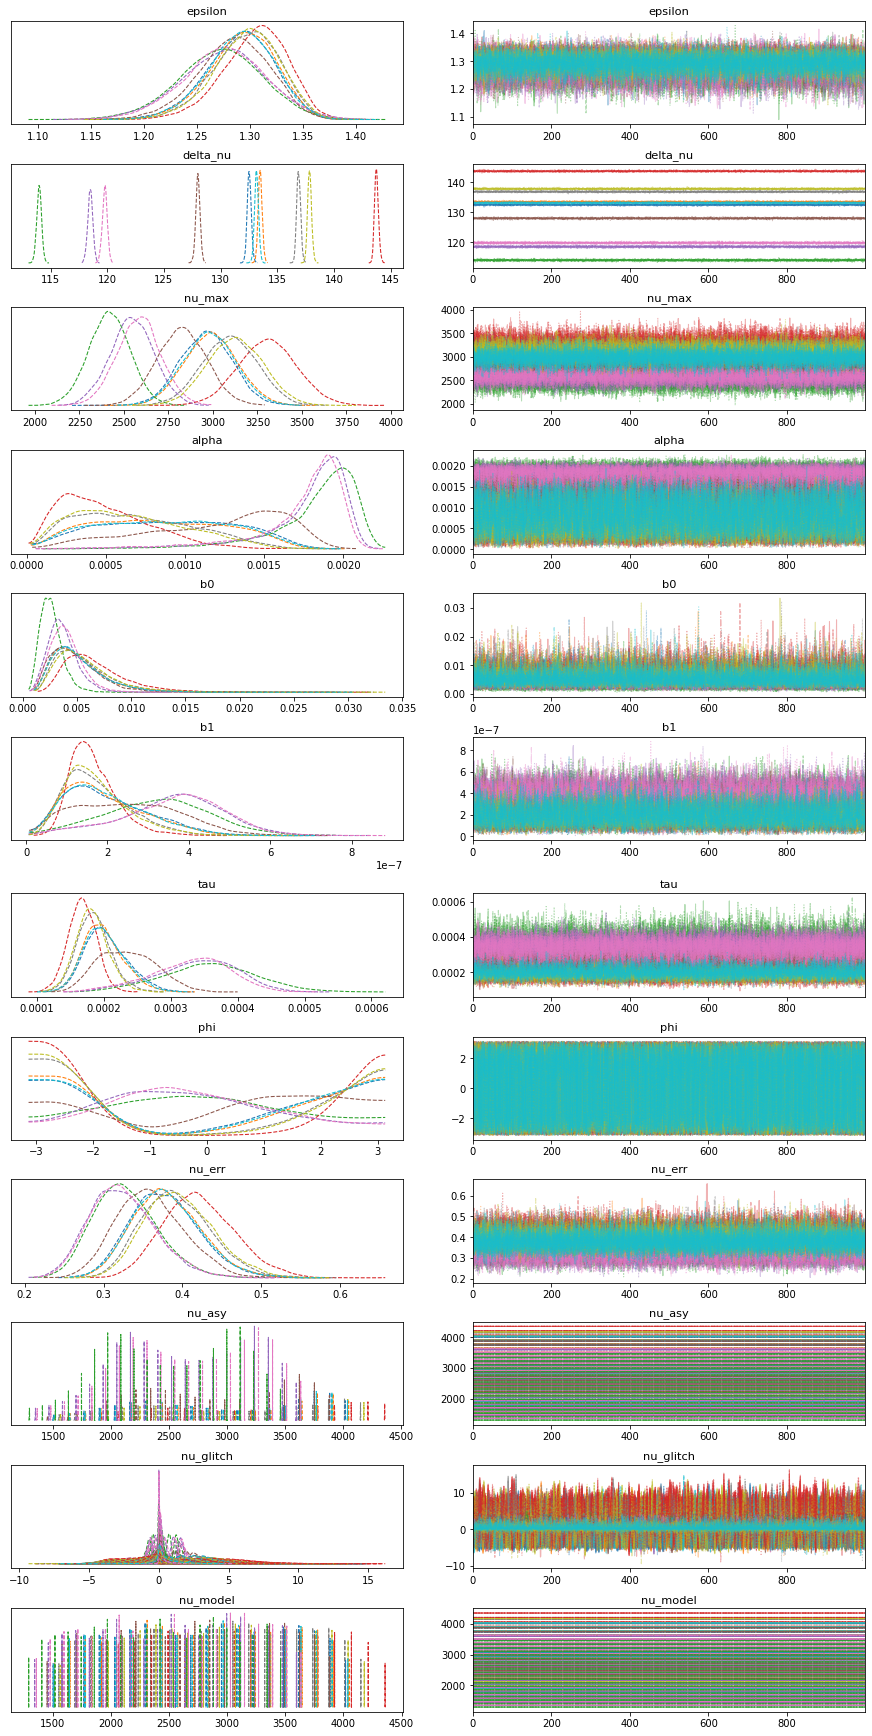

In [26]:
with model_glitch_he:
    ax = az.plot_trace(trace_glitch_he, compact=True, combined=True)

In [28]:
with pm.Model() as model_glitch_hecz:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2, shape=n_stars)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0, shape=n_stars)
    delta_nu = pm.Normal('delta_nu', dnus, 1.0, shape=n_stars)
    nu_max = pm.Normal('nu_max', numaxs, numaxs*0.05, shape=n_stars)
    
    b0 = pm.Lognormal('b0', np.log(1/numaxs), 1.0, shape=n_stars)
    b1 = pm.Lognormal('b1', np.log(1/numaxs**2), 1.0, shape=n_stars)
    tau_he = pm.Lognormal('tau_he', np.log(0.0005), 0.5, shape=n_stars)

#     log_tau = pm.Normal('log_tau', 0.0 + -0.99 * np.log(numax), 0.6)
#     tau = pm.Deterministic('tau', tt.exp(log_tau))

    phi_he = pm.VonMises('phi_he', 0.0, 0.1, shape=n_stars)

    
    # BCZ glitch
    c0 = pm.Lognormal('c0', np.log(numaxs**2), 1.0, shape=n_stars)
    tau_cz = pm.Lognormal('tau_cz', tt.log(0.001), 0.8, shape=n_stars)
    phi_cz = pm.VonMises('phi_cz', 0.0, 0.1, shape=n_stars)
    
    delta_tau_logp = pm.Lognormal.dist(np.log(0.001), 0.8, shape=n_stars).logp(tau_cz - tau_he)
    delta_tau = pm.Potential('delta_tau', delta_tau_logp)
    
    nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(ns, epsilon, alpha, delta_nu, nu_max))

    amp_he = pm.Deterministic('amp_he', he_amplitude(nu_asy, b0, b1))
    amp_cz = pm.Deterministic('amp_cz', cz_amplitude(nu_asy, c0))
    
#     delta_amp_logp = pm.Lognormal.dist(np.log(0.1), 0.5).logp(amp_cz/amp_he)
#     delta_amp = pm.Potential('delta_amp', delta_amp_logp)
    
#     dnu_he = pm.Deterministic('dnu_he', he_glitch(nu_asy, b0, b1, tau_he, phi_he))
#     dnu_cz = pm.Deterministic('dnu_cz', cz_glitch(nu_asy, c0, tau_cz, phi_cz))
    
    dnu_he = pm.Deterministic('dnu_he', amp_he * glitch(nu_asy, tau_he, phi_he))
    dnu_cz = pm.Deterministic('dnu_cz', amp_cz * glitch(nu_asy, tau_cz, phi_cz))

    nu_model = pm.Deterministic('nu_model', nu_asy + dnu_he + dnu_cz)

#     nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)
    
#     nu_asy = pm.Deterministic('nu_asy', asy_background(ns, epsilon, alpha, delta_nu, nu_max))
#     nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau_he, phi_he))
    
#     nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)

    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nus)

In [29]:
with model_glitch_hecz:
    trace_glitch_hecz = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:25.493140
Transformation time =  0 days 00:28:32.340054


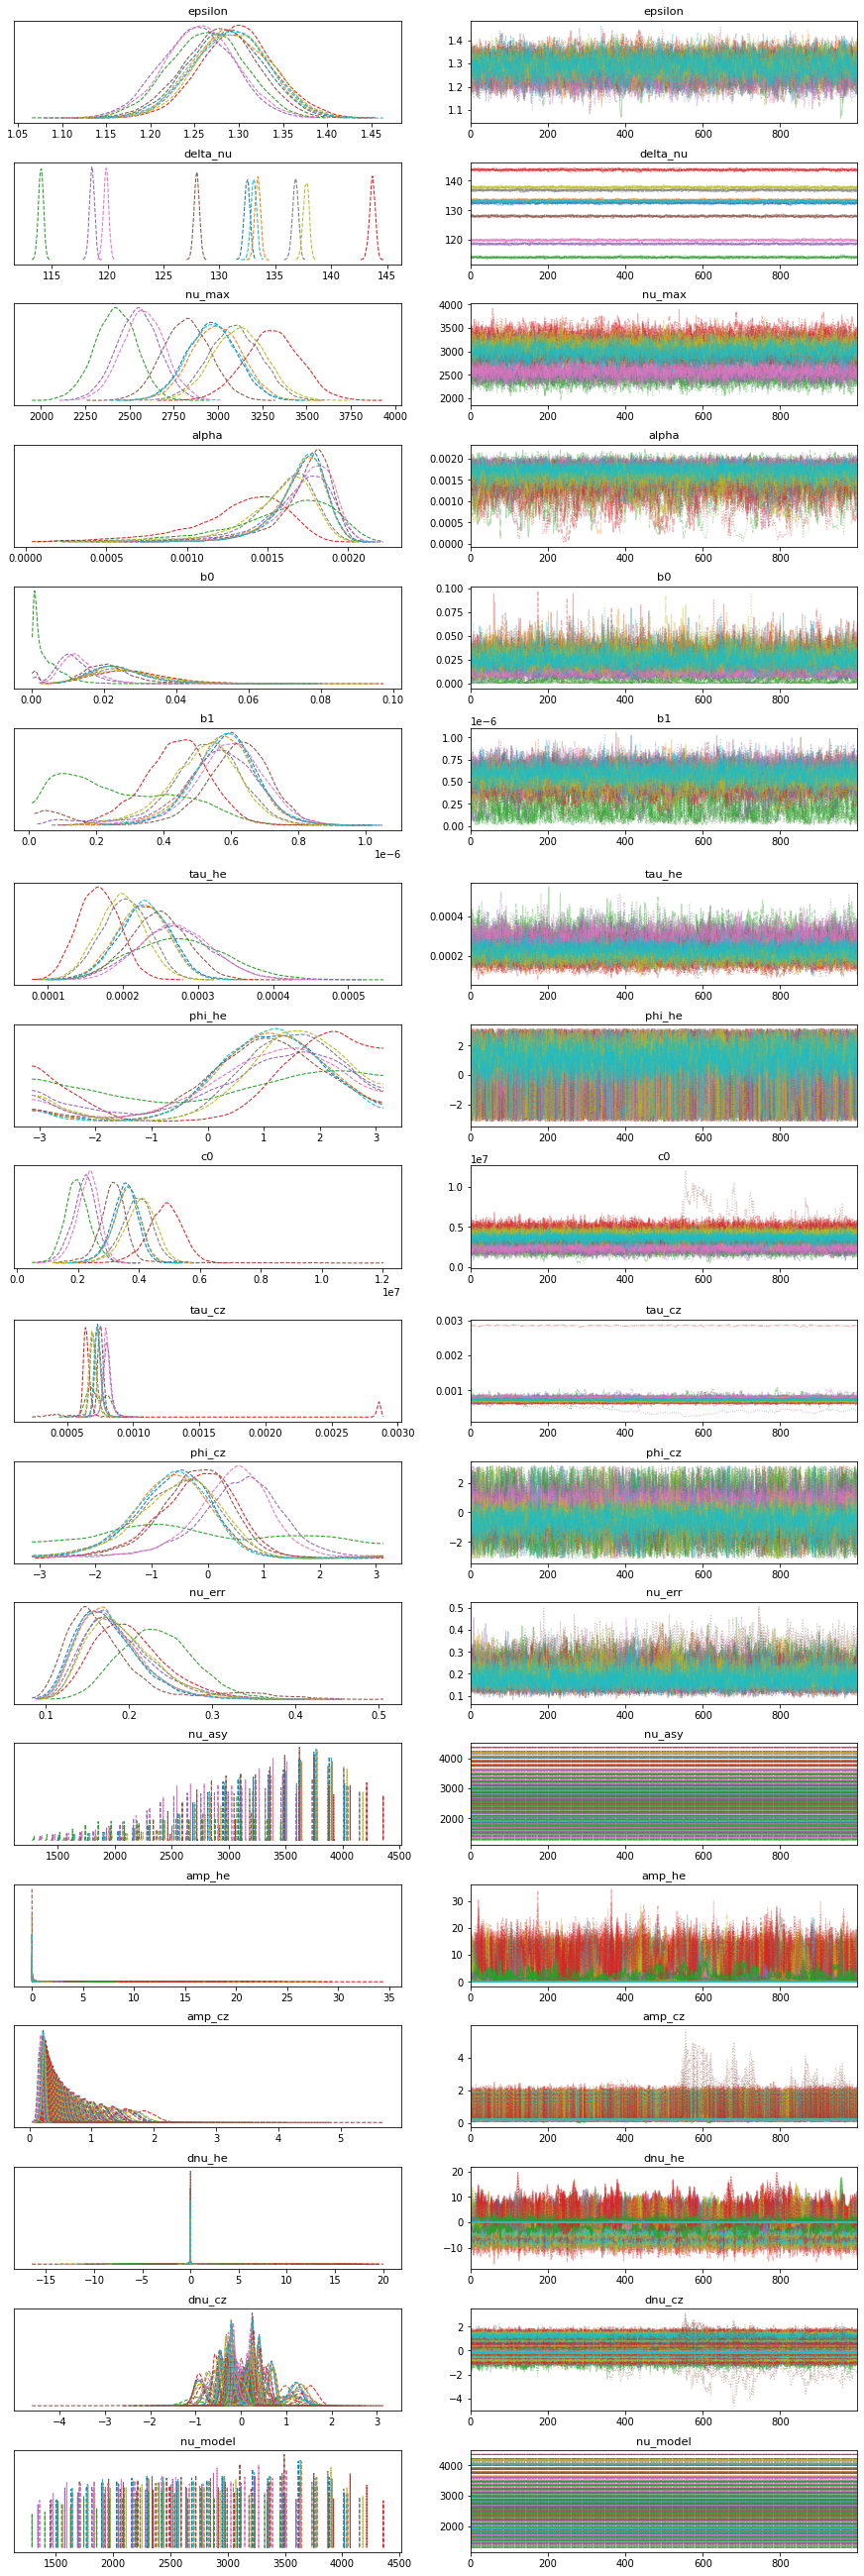

In [30]:
with model_glitch_hecz:
    ax = az.plot_trace(trace_glitch_hecz, compact=True, combined=True)

In [38]:
b0 = trace_glitch_hecz.posterior[['b0', 'b1', 'tau_he']].values()

In [56]:
b0 = az.summary(trace_glitch_hecz, var_names='b0', round_to='none')
b1 = az.summary(trace_glitch_hecz, var_names='b1', round_to='none')
tau_he = az.summary(trace_glitch_hecz, var_names='tau_he', round_to='none')

In [71]:
he = profiles['surface_he4']

In [102]:
a_numax = he_amplitude(numaxs, b0['mean'].to_numpy(), b1['mean'].to_numpy(), lib=np)

In [103]:
a_numax_err = np.reshape(he_amplitude(numaxs, trace_glitch_hecz.posterior['b0'].values,
                        trace_glitch_hecz.posterior['b1'].values, lib=np),
           (10*1000, 10)).std(axis=0)

<ErrorbarContainer object of 3 artists>

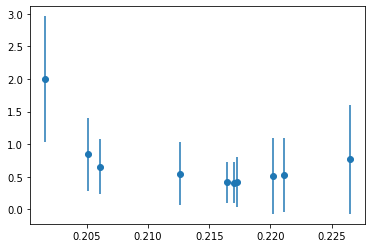

In [104]:
plt.errorbar(he, a_numax, a_numax_err, fmt='o')

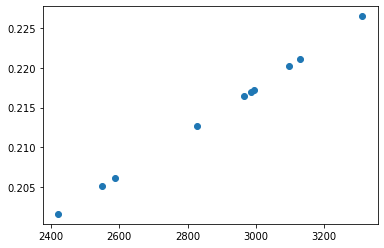

In [105]:
plt.scatter(numaxs, he)

In [75]:
a_2000 = he_amplitude(2000., b0['mean'].to_numpy(), b1['mean'].to_numpy(), lib=np)
a_2000_sd = he_amplitude(2000., b0['mean'].to_numpy(), b1['mean'].to_numpy(), lib=np)

In [86]:
a_2000_err = np.reshape(he_amplitude(2000., trace_glitch_hecz.posterior['b0'].values,
                        trace_glitch_hecz.posterior['b1'].values, lib=np),
           (10*1000, 10)).std(axis=0)

<ErrorbarContainer object of 3 artists>

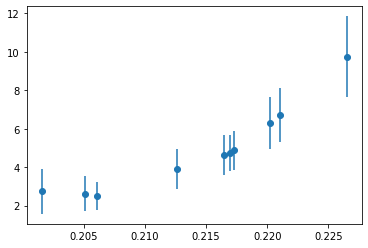

In [87]:
plt.errorbar(he, a_2000, a_2000_err, fmt='o')

In [88]:
a_3000 = he_amplitude(3000., b0['mean'].to_numpy(), b1['mean'].to_numpy(), lib=np)
a_3000_sd = he_amplitude(3000., b0['mean'].to_numpy(), b1['mean'].to_numpy(), lib=np)

In [89]:
a_3000_err = np.reshape(he_amplitude(3000., trace_glitch_hecz.posterior['b0'].values,
                        trace_glitch_hecz.posterior['b1'].values, lib=np),
           (10*1000, 10)).std(axis=0)

<ErrorbarContainer object of 3 artists>

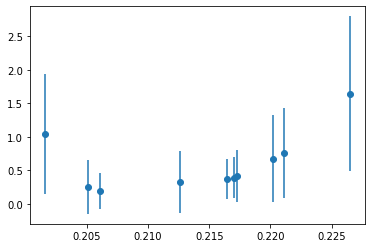

In [90]:
plt.errorbar(he, a_3000, a_3000_err, fmt='o')

<ErrorbarContainer object of 3 artists>

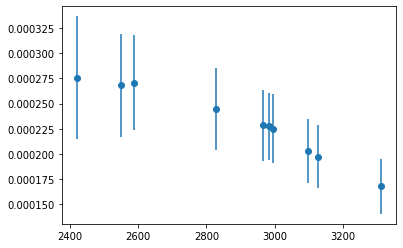

In [94]:
plt.errorbar(numaxs, tau_he['mean'], tau_he['sd'], fmt='o')

<ErrorbarContainer object of 3 artists>

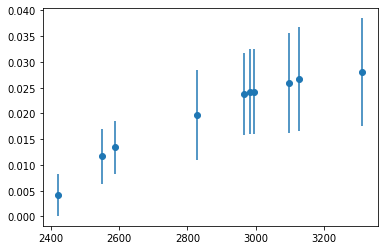

In [96]:
plt.errorbar(numaxs, b0['mean'], b0['sd'], fmt='o')

<ErrorbarContainer object of 3 artists>

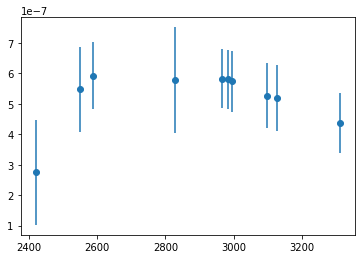

In [97]:
plt.errorbar(numaxs, b1['mean'], b1['sd'], fmt='o')

Now we pool tau using a relation tested earlier

In [138]:
with pm.Model() as model_glitch_pooled:
    
    c = pm.Normal('c', 0.0, 0.1)
    m = pm.Normal('m', 1.0, 0.05)
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2, shape=n_stars)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0, shape=n_stars)
    delta_nu = pm.Normal('delta_nu', dnus, 1.0, shape=n_stars)
    nu_max = pm.Normal('nu_max', numaxs, numaxs*0.05, shape=n_stars)
    
    b0 = pm.Lognormal('b0', np.log(1/numaxs), 1.0, shape=n_stars)
    b1 = pm.Lognormal('b1', np.log(1/numaxs**2), 1.0, shape=n_stars)
#     tau = pm.Deterministic('tau', d * nu_max**(-m))

    log_tau = pm.Normal('log_tau', c - m * tt.log(nu_max), 0.6, shape=n_stars)
    tau = pm.Deterministic('tau', tt.exp(log_tau))

    phi = pm.VonMises('phi', 0.0, 0.1, shape=n_stars)

    nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(ns, epsilon, alpha, delta_nu, nu_max))
    nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau, phi))
    
    nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)

    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nus)

In [139]:
with model_glitch_pooled:
    trace_glitch_pooled = sampling_jax.sample_numpyro_nuts(tune=2000, chains=4, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:21.797877
Transformation time =  0 days 00:04:55.438378


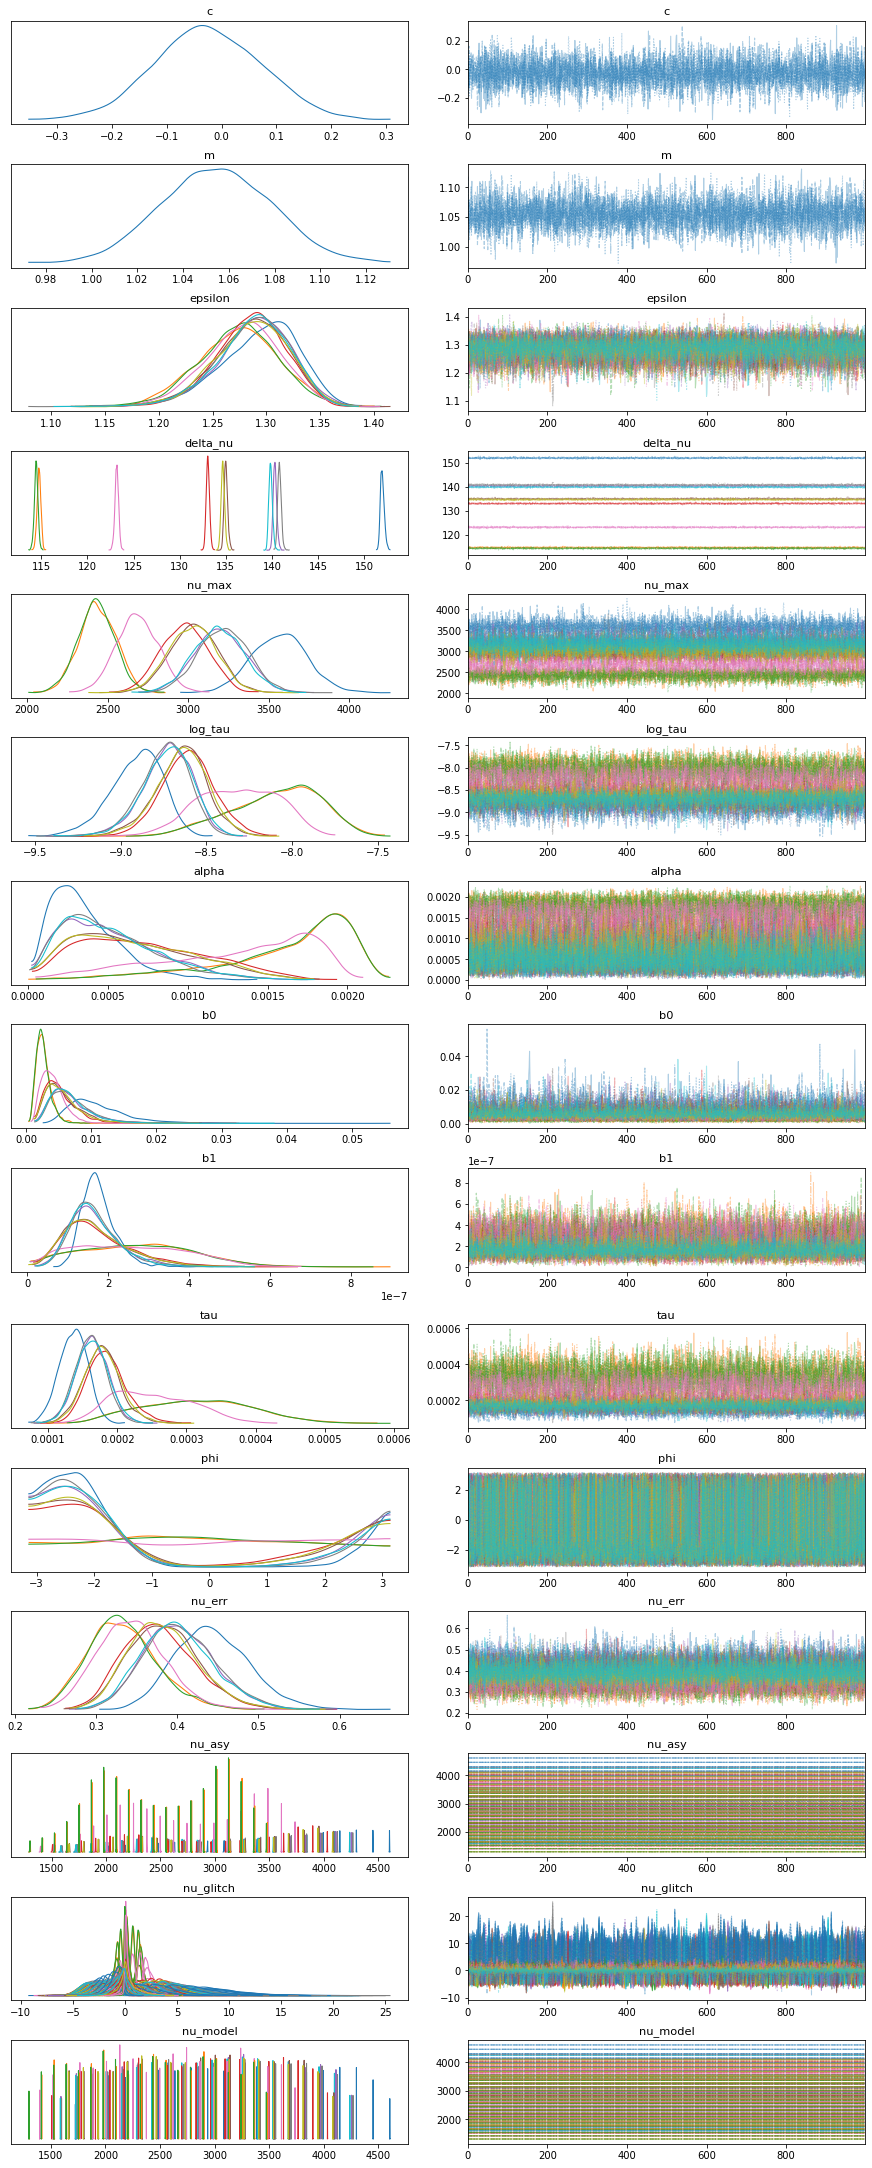

In [140]:
with model_glitch_pooled:
    ax = az.plot_trace(trace_glitch_pooled, compact=True, combined=True)